Q-1. Take any YouTube videos link and your task is to extract the comments from
that videos and store it in a csv file and then you need define what is most
demanding topic in that videos comment section.

In [5]:
from googleapiclient.discovery import build
import csv
import json
import pandas as pd

In [6]:
config_file_name = "config.json"

with open(config_file_name) as config_file:
    config = json.load(config_file)
api_key = config["API_KEY"]
video_id = config["VIDEO_ID"]

In [ ]:
# recursive function to get all replies in a comment thread
def get_replies(comment_id, token):
    replies_response = yt_object.comments().list(part = 'snippet', maxResults = 100, parentId = comment_id, pageToken = token, textFormat="plainText").execute()

    for reply in replies_response['items']:
        all_comments.append(reply['snippet']['textDisplay'])

    if replies_response.get("nextPageToken"):
        return get_replies(comment_id, replies_response['nextPageToken'])
    else:
        return []


# recursive function to get all comments
def get_comments(youtube, video_id, next_view_token):
    global all_comments

    # check for token
    if len(next_view_token.strip()) == 0:
        all_comments = []

    if next_view_token == '':
        # get the initial response
        comment_list = youtube.commentThreads().list(part = 'snippet', maxResults = 100, videoId = video_id, order = 'relevance').execute()
    else:
        # get the next page response
        comment_list = youtube.commentThreads().list(part = 'snippet', maxResults = 100, videoId = video_id, order='relevance', pageToken=next_view_token).execute()
    # loop through all top level comments
    for comment in comment_list['items']:
        # add comment to list
        all_comments.append([comment['snippet']['topLevelComment']['snippet']['textDisplay']])
        # get number of replies
        reply_count = comment['snippet']['totalReplyCount']
        all_replies = []
        # if replies greater than 0
        if reply_count > 0:
            # get first 100 replies
            replies_list = youtube.comments().list(part='snippet', maxResults=100, parentId=comment['id']).execute()
            for reply in replies_list['items']:
                # add reply to list
                all_replies.append(reply['snippet']['textDisplay'])

            # check for more replies
            while "nextPageToken" in replies_list:
                token_reply = replies_list['nextPageToken']
                # get next set of 100 replies
                replies_list = youtube.comments().list(part = 'snippet', maxResults = 100, parentId = comment['id'], pageToken = token_reply).execute()
                for reply in replies_list['items']:
                    # add reply to list
                    all_replies.append(reply['snippet']['textDisplay'])

        # add all replies to the comment
        all_comments[-1].append(all_replies)

    if "nextPageToken" in comment_list:
        return get_comments(youtube, video_id, comment_list['nextPageToken'])
    else:
        return []


all_comments = []

# build a youtube object using our api key
yt_object = build('youtube', 'v3', developerKey=api_key)

# get all comments and replies
comments = get_comments(yt_object, video_id, '')


'''
with open('all_comments.json', 'w', encoding='utf-8') as f:
  for comment, replies in all_comments:
    json.dump(comment, f, indent=4)
    if len(replies)>0:
      json.dump(replies, f, indent=4)
      for reply in replies:
        json.dump(reply, f, indent=4)
'''

'''
with open('all_comments.csv', 'w', encoding='utf-8') as f:
  writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for comment, replies in all_comments:
    writer.writerow(str(comment))
    if len(replies)>0:
      writer.writerow(str(replies))
      for reply in replies:
        writer.writerow(str(reply))
'''


'''
df_comment.to_csv(FILE_NAME, mode='a', encoding='utf-8', index=False, header=False)
'''

In [8]:
df= pd.DataFrame(all_comments)

In [9]:
df.to_csv('all_comments.csv', index=False, encoding='utf-8')

In [11]:
import  nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
comments_list= pd.read_csv('all_comments.csv').values.tolist()

In [ ]:
comments_list

In [ ]:
comment_replies= ""
for comments, replies in comments_list:
  comment_replies+=comments+ replies


In [72]:
comment_replies= comment_replies.strip() # remove whitespace

In [73]:
comment_replies= comment_replies.replace("\n", " ") # replace newlines with space

In [165]:
char_remov= "-,!,[,],;,&,#,(,?,:,@,|,http,\:,\\,https,?,\:,//,www,\,\')".split(',') # remove mentions and links
for char in char_remov:
    # replace() "returns" an altered string
    comment_replies = comment_replies.replace(char, "")

In [166]:
comment_replies= comment_replies.replace(r"[^\w\s]+", "") # remove punctuations, emojis, special characters

In [167]:
comment_replies= comment_replies.replace(",", "")

In [168]:
comment_replies=comment_replies.lower() # turn to lowercase

In [169]:
stop_words= stopwords.words('english')

In [171]:
clean_words= [w for w in comment_replies.split(" ") if w not in stop_words]

In [189]:
fd= nltk.FreqDist(w.lower() for w in clean_words if len(w)>3)

In [190]:
fd

FreqDist({'film': 69, 'color': 23, 'shoot': 21, 'love': 18, 'portra': 18, 'like': 15, 'good': 12, 'rolls': 12, 'know': 12, 'it39s': 11, ...})

In [191]:
wc= WordCloud().generate_from_frequencies(fd)

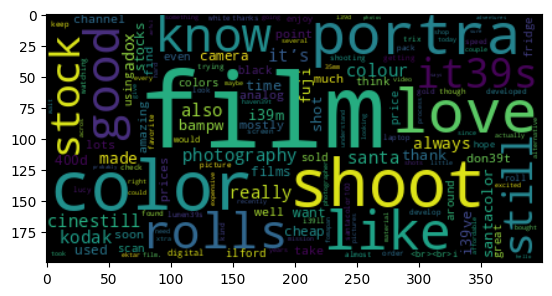

In [192]:
plt.figure()
plt.imshow(wc, interpolation= 'bilinear')

From the above analysis it is clear that the most demanding topic in that videos comment section is 'film'.